total work days: 781

9 aug: 562
9 nov: 628


In [1]:
#!pip cell

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
np.random.seed(42)
criterion=torch.nn.MSELoss()

In [5]:
stock = pd.read_csv('/content/drive/My Drive/simulation/smi.csv',parse_dates=True,index_col='Date')
stock.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-14,11116.309570,11129.500000,10993.099609,10999.589844,10999.589844,41997000
2022-11-15,11008.889648,11087.419922,10991.740234,11026.219727,11026.219727,40182400
2022-11-16,11022.349609,11022.349609,10922.450195,10936.620117,10936.620117,36685200
2022-11-17,10962.280273,10993.110352,10838.799805,10917.879883,10917.879883,32549600
2022-11-18,10991.629883,11063.879883,10949.419922,11045.490234,11045.490234,44285900


In [19]:
interest_rate = pd.read_excel('/content/drive/My Drive/simulation/interestrate.xlsx',parse_dates=True)
interest_rate=interest_rate.dropna()
interest_rate.head(5)

,Date,Rate
0,2023-08-09,1.94
1,2023-08-10,1.94
2,2023-08-11,1.92
5,2023-08-14,1.92
6,2023-08-15,1.90


In [20]:
gt = pd.read_excel('/content/drive/My Drive/simulation/gt.xlsx',parse_dates=True)
gt=gt.dropna()
gt.head(5)

,Date,Price
0,2023-08-09,948.81
1,2023-08-10,953.56
2,2023-08-11,948.12
5,2023-08-14,949.99
6,2023-08-15,941.62


In [21]:
mask = (gt['Date'] > '2023-10-09') & (gt['Date'] <= '2023-11-09')
last_month = gt.loc[mask]
last_month.head(5)

,Date,Price
62,2023-10-10,948.83
63,2023-10-11,951.12
64,2023-10-12,947.15
65,2023-10-13,940.65
68,2023-10-16,939.68


**Get 3 months's data**

Assuming we are simulating price of Aug 9, we need 3 month's stock's data prior

In [22]:
mask_3_months = (gt['Date'] >= '2023-08-09') & (gt['Date'] <= '2023-11-09')
rel_3_months = gt.loc[mask_3_months]

In [23]:
from sklearn.metrics import mean_squared_error

def calculate_mse(simulated_paths, reference_prices, avg = False):
    """
    Calculate the Mean Squared Error (MSE) between simulated prices and reference prices.

    Parameters:
    - simulated_paths: List of simulated prices across paths (each element is an array of prices).
    - reference_prices: Reference prices (e.g., stock['Adj Close']).

    Returns:
    - mse: Mean Squared Error.
    """
    if avg == False:
      avg_simulated_prices = np.mean(simulated_paths, axis=1)
    else:
      avg_simulated_prices = simulated_paths
    mse = mean_squared_error(avg_simulated_prices, reference_prices)
    return mse



In [24]:
relevant_data = stock.loc['2023-5-9':'2023-8-9']  #do we need stock price on Aug 9??? CHECK
relevant_data.sort_values(by='Date', ascending = True, inplace = True)
result = relevant_data['Adj Close'].values

<ipython-input-24-64a223a9b1a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


In [25]:
def gbmsim(Nsim,S0,v,sigma,Deltat,m, Z_all = None, return_z=False):
  #m number of periods
  S=[[S0 for x in range(m+1)] for y in range(Nsim)]
  if Z_all is None:
    Z_all=[]
    for i in range(Nsim):
      Z = [np.random.normal() for x in range(m)]

      for j in range(1,m+1):
        S[i][j]=S[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[j-1])

      Z_all.append(Z)

  else:
    for i in range(Nsim):
      Z = Z_all[i]

      for j in range(1,m+1):
        S[i][j]=S[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[j-1])

  if return_z==True:
    return S,Z_all

  else:
    return S

In [26]:
# payoff function
def pay_off(sims,period,r_treasury=2.5/100/252,enable_rigorous=False,return_path=False,enable_torch=False):
  '''
  sims: whole of simulations, [price of day1, price of day2 ... price of dayT]
  period from start of simulation to Maturity date, measured in day

  returns: expected pay off discounted back to current date, and a list of expected pay-offs.
  '''
  r=2.5/100 #yearly interest rate on Cash Component
  S0 = 11841.30 #Initial fixing date price
  S1= 11249.2350  #first trigger level
  S2= 10657.1700  #second trigger level
  S3= 10065.1050  #third trigger level
  t1= 192 #working day from initial fixing date to first trigger event
  t2= 265 #working day from initial fixing date to second trigger event
  triggered=False
  PT=[] #Pay off at maturity date T for all the paths in simulation

  for S in sims:
    for idx in range(len(S)):
      daily_price=S[idx]
      if daily_price<S3:
        triggered=True
        t3=562+idx  #working day from initial fixing date to third trigger event
        break
    if enable_rigorous:
      raise NotImplementedError
      #No need because all r_treasury<2.5
    else:
      if triggered:
        pay_off_at_T=550*S[-1]/S0+150*S[-1]/S1+150*S[-1]/S2+150*S[-1]/S3

      else:
        pay_off_at_T=550*S[-1]/S0+150*S[-1]/S1+150*S[-1]/S2+(1000-550-150-150)*(r+1)**3

    PT.append(pay_off_at_T)

  #Take expectation
  pay_off_at_T = sum(PT)/len(PT)

  if enable_torch:
    if return_path:
      return torch.tensor(PT)*torch.exp(-r_treasury*period)
    else:
      #Discount_back
      return pay_off_at_T*torch.exp(-r_treasury*period)

  else:
    if return_path:
      return np.array(PT)*np.exp(-r_treasury*period)
    else:
      #Discount_back
      return pay_off_at_T*np.exp(-r_treasury*period)



**Simulate under risk-neutral world**

In [27]:
relevant_data = stock.loc[f'2023-11-8':'2023-11-9']
relevant_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-08,10542.530273,10645.219727,10530.509766,10595.059570,10595.059570,27276900
2023-11-09,10608.730469,10691.049805,10585.080078,10644.990234,10644.990234,21508600


In [28]:
def simulate_price_path_gbm(h=0.01,rolling_rate=False, last_month=False):
  path = []
  var = []
  ci = []
  delta = []
  gamma = []
  sigma_all = []
  for idx, date in enumerate(interest_rate['Date']):
    orig_date=date
    split_date = str(date).split('-')
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
      continue
    else:
      relevant_data = stock.loc[f'2023-{month-3}-{day}':date]  #do we need stock price on Aug 9??? CHECK
      relevant_data.sort_values(by='Date', ascending = True, inplace = True)
      result = relevant_data['Adj Close'].values
      n0=len(result)
      dt = 1/781 #I forgot, is it daily?
      logprices=np.log(result)
      logreturns = logprices[2:n0]-logprices[1:(n0-1)]
      mu=sum(logreturns)/n0/dt
      sigma=np.std(logreturns)/np.sqrt(dt)
      St=result[n0-1] #Starting price at current date t
      Nsim=100  #Number of simulation
      m = 781-562-idx #Number of workings between Aug 9 and final fixing date
      sigma_all.append(sigma)

      if not rolling_rate:
        r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
      else:
        # r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
        mask = (interest_rate['Date'] >= f'2023-{month-3}-{day}') & (interest_rate['Date'] <= date)
        r=interest_rate.loc[mask]
        r = sum(r['Rate'].values)/m/100/252

      print(m)
      print
      true_mu=r-sigma**2/2  #true_mu is the mu adjusted to risk-neutral valuation

      sim_result, Z_all = gbmsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
      one_path = pay_off(sim_result,781-562-idx,r_treasury = r, return_path=True)

      mean = sum(one_path)/len(one_path)
      var.append(np.std(one_path))
      ci.append((mean-1.96*np.std(one_path),mean+1.96*np.std(one_path)))
      path.append(mean)

      s_minus_h=gbmsim(Nsim,St-h,true_mu,sigma,dt,m,Z_all=Z_all)
      s_plus_h=gbmsim(Nsim,St+h,true_mu,sigma,dt,m,Z_all=Z_all)
      f_splush=pay_off(s_plus_h,781-562-idx,r_treasury = r)
      f_sminush=pay_off(s_minus_h,781-562-idx,r_treasury = r)

      delta.append((f_splush-f_sminush)/2/h)
      gamma.append((f_splush+f_sminush-mean*2)/h**2)

  print(f"sigma: {sum(sigma_all)/len(sigma_all)}")
  return path, var, ci, delta, gamma


3 months: 
219
218


<ipython-input-28-f63a9f3d05bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
sigma: 0.1851682190324757


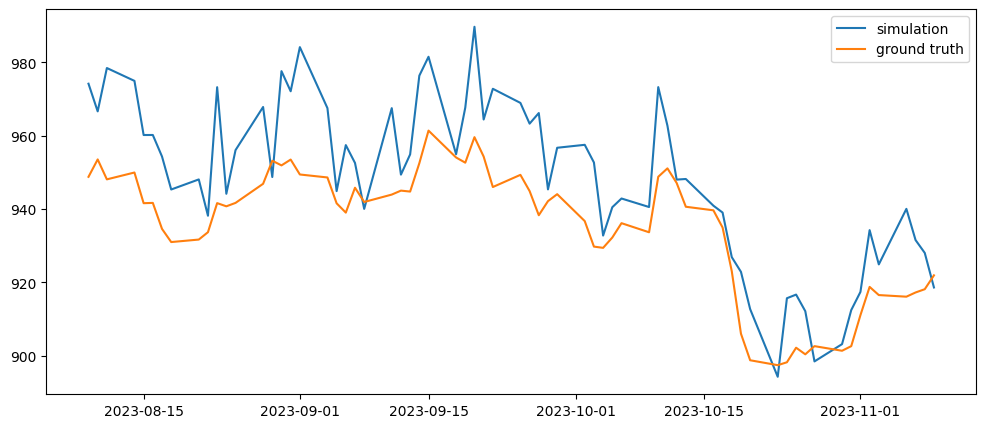

ERROR: 273.3800752791446
var:  85.46598979970106


In [29]:
# print("using one rate: ")
# simulated_path_gbm_one_rate = simulate_price_path_gbm()
# plt.plot(interest_rate['Date'],simulated_path_gbm_one_rate,label = "simulation")
# plt.plot(gt['Date'],gt['Price'],label = "ground truth")
# plt.legend()
# plt.show()
print("3 months: ")
simulated_path_gbm_rolling_rates, var_orig,ci,delta,gamma = simulate_price_path_gbm(rolling_rate=False)
plt.figure(figsize=(12,5))
plt.plot(interest_rate['Date'],simulated_path_gbm_rolling_rates,label = "simulation")
plt.plot(gt['Date'],gt['Price'],label = "ground truth")
plt.legend()
# plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates),torch.tensor(gt['Price'].values))}")
print("var: ", np.mean(var_orig))


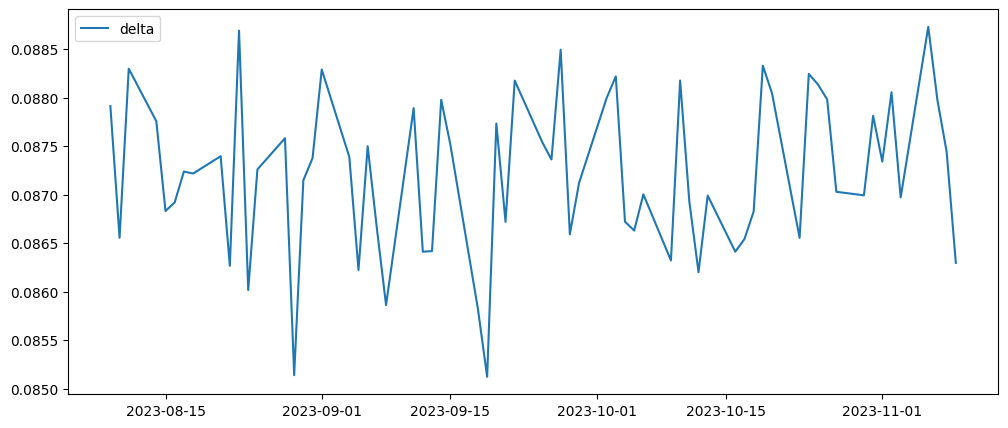

0.087213674407255


In [30]:
plt.figure(figsize=(12,5))
plt.plot(interest_rate['Date'],delta,label = "delta")
plt.legend()
# plt.legend()
plt.show()
print(np.mean(delta))

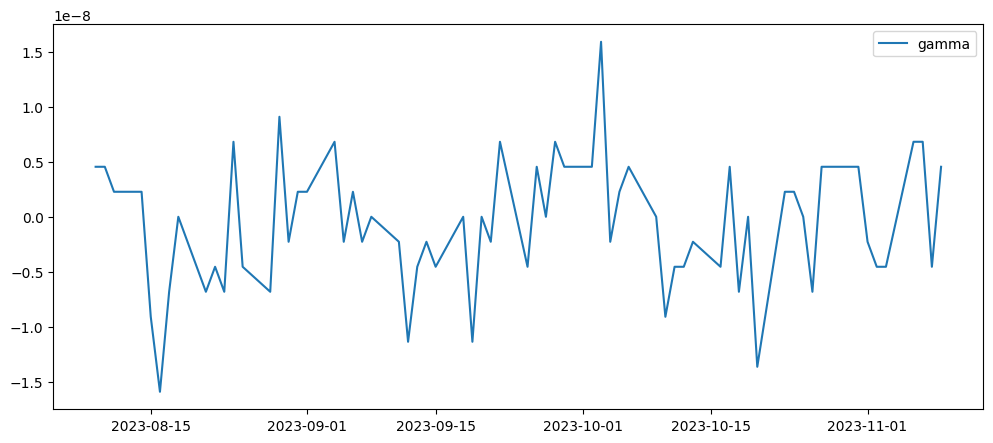

-7.126637588519214e-10


In [31]:
plt.figure(figsize=(12,5))
plt.plot(interest_rate['Date'],gamma,label = "gamma")
plt.legend()
# plt.legend()
plt.show()
print(np.mean(gamma))

In [32]:
mse_result_gbm = calculate_mse(simulated_path_gbm_rolling_rates, rel_3_months['Price'], avg=True)

print(f"Mean Squared Error (MSE): {mse_result_gbm}")

Mean Squared Error (MSE): 273.38007527914453


one month: 
175
174


<ipython-input-28-f63a9f3d05bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
sigma: 0.184084404768038


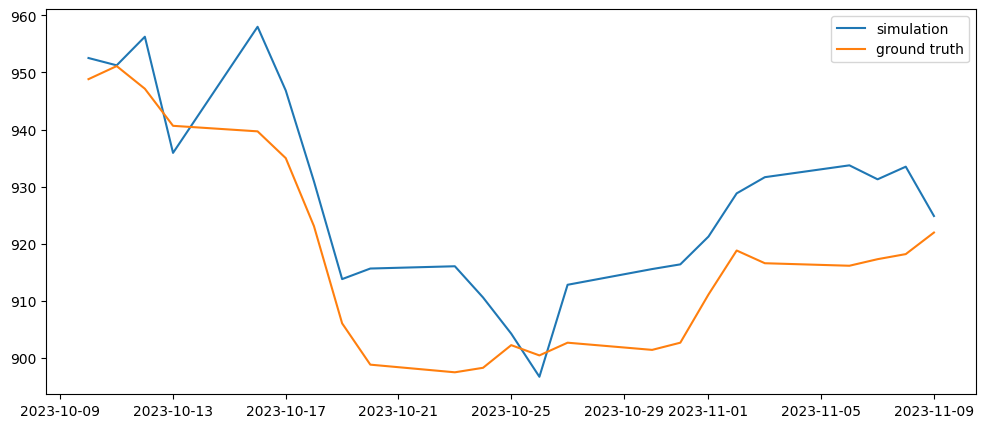

ERROR: 138.68978324248755
var:  76.414325440225


In [33]:
print("one month: ")
simulated_path_gbm_rolling_rates_one_month,var,ci,delta,gamma = simulate_price_path_gbm(rolling_rate=False,last_month=True)
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],simulated_path_gbm_rolling_rates_one_month,label = "simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
# plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_one_month),torch.tensor(last_month['Price'].values))}")
print("var: ", np.mean(var))

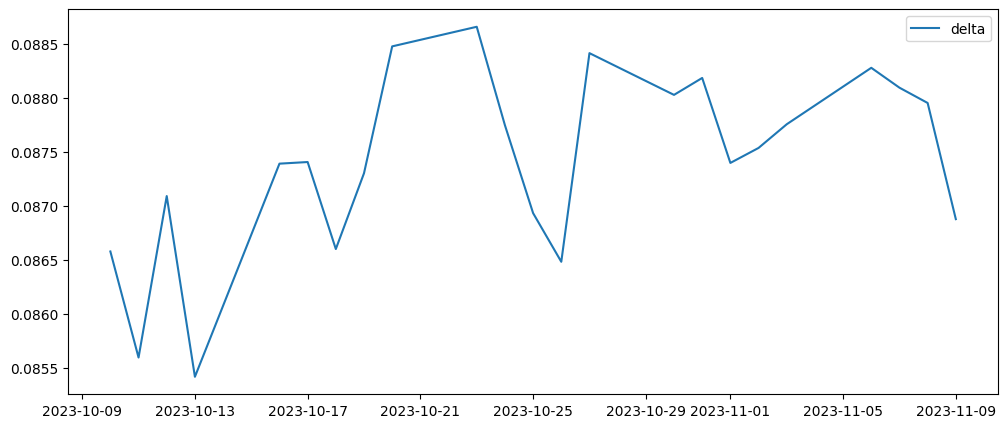

0.08740249432410406


In [34]:
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],delta,label = "delta")
plt.legend()
# plt.legend()
plt.show()
print(np.mean(delta))

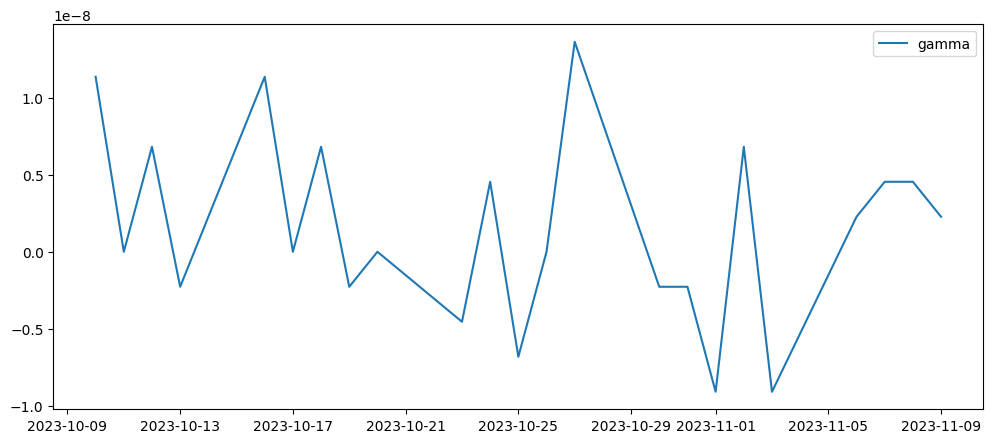

1.5817299161268318e-09


In [35]:
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],gamma,label = "gamma")
plt.legend()
# plt.legend()
plt.show()
print(np.mean(gamma))

AV simulation

In [36]:
 def gbmavsim(Nsim,S0,v,sigma,Deltat,m,Z_all = None, return_z=False):
  #m number of periods
  Nsim=Nsim//2
  S=[[S0 for x in range(m+1)] for y in range(Nsim)]
  S_tilde=[[S0 for x in range(m+1)] for y in range(Nsim)]
  if Z_all is None:
    Z_all=[]
    for i in range(Nsim):
      Z = [np.random.normal() for x in range(m)]

      for j in range(1,m+1):
        S[i][j]=S[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[j-1])
        S_tilde[i][j]=S_tilde[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[j-1]*(-1))
      Z_all.append(Z)

  else:
    for i in range(Nsim):
      Z =Z_all[i]

      for j in range(1,m+1):
        S[i][j]=S[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[j-1])
        S_tilde[i][j]=S_tilde[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[j-1]*(-1))

  out = []
  for i in range(Nsim):
        out.append(S[i])
        out.append(S_tilde[i])

  if return_z:
    return out, Z_all

  else:
    return out

In [37]:
def simulate_price_path_gbm_av(h=0.01,avg_rate=True,last_month=False):
  path = []
  var = []
  ci = []
  delta = []
  gamma = []
  for idx, date in enumerate(interest_rate['Date']):
    orig_date=date
    split_date = str(date).split('-')
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
      continue
    relevant_data = stock.loc[f'2023-{month-3}-{day}':date]  #do we need stock price on Aug 9??? CHECK
    relevant_data.sort_values(by='Date', ascending = True, inplace = True)
    result = relevant_data['Adj Close'].values
    n0=len(result)
    dt = 1/781 #I forgot, is it daily?
    logprices=np.log(result)
    logreturns = logprices[2:n0]-logprices[1:(n0-1)]
    mu=sum(logreturns)/n0/dt
    sigma=np.std(logreturns)/np.sqrt(dt)
    St=result[n0-1] #Starting price at current date t
    Nsim=100  #Number of simulation
    m = 781-562-idx #Number of workings between Aug 9 and final fixing date

    if avg_rate:
      r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
    else:
      r =interest_rate[interest_rate['Date']==orig_date]['Rate'].values[0]/100/252
    true_mu=r-sigma**2/2  #true_mu is the mu adjusted to risk-neutral valuation

    sim_result, Z_all = gbmavsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
    one_path = pay_off(sim_result,781-562-idx,r_treasury = r, return_path=True)

    mean = sum(one_path)/len(one_path)
    var.append(np.std(one_path))
    ci.append((mean-1.96*np.std(one_path),mean+1.96*np.std(one_path)))
    path.append(mean)

    s_minus_h=gbmavsim(Nsim,St-h,true_mu,sigma,dt,m,Z_all=Z_all)
    s_plus_h=gbmavsim(Nsim,St+h,true_mu,sigma,dt,m,Z_all=Z_all)
    f_splush=pay_off(s_plus_h,781-562-idx,r_treasury = r)
    f_sminush=pay_off(s_minus_h,781-562-idx,r_treasury = r)

    delta.append((f_splush-f_sminush)/2/h)
    gamma.append((f_splush+f_sminush-mean*2)/h**2)

  return path, var, ci, delta, gamma

Three Months: 


<ipython-input-37-1619e58ca844>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


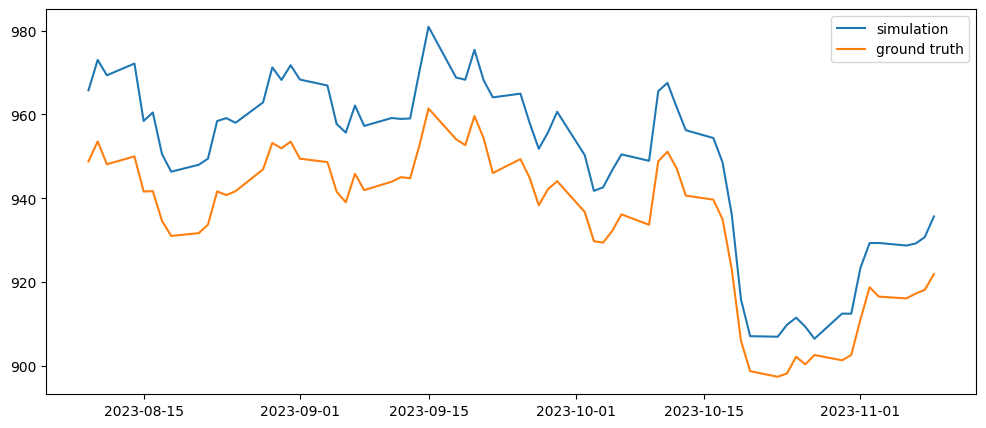

ERROR: 227.15229900158886
var:  84.66232082258045


In [38]:
# print("using one rate: ")
# simulated_path_gbm_one_rate_av = simulate_price_path_gbm_av()
# plt.plot(interest_rate['Date'],simulated_path_gbm_one_rate_av)

# # plt.legend()
# plt.show()
plt.figure(figsize=(12,5))
print("Three Months: ")
simulated_path_gbm_rolling_rates_av,var_av, ci, delta, gamma = simulate_price_path_gbm_av(avg_rate=False)
plt.plot(interest_rate['Date'],simulated_path_gbm_rolling_rates_av,label = "simulation")
plt.plot(gt['Date'],gt['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_av),torch.tensor(gt['Price'].values))}")
print("var: ", np.mean(var_av))

One Month: 
Three Months: 


<ipython-input-37-1619e58ca844>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


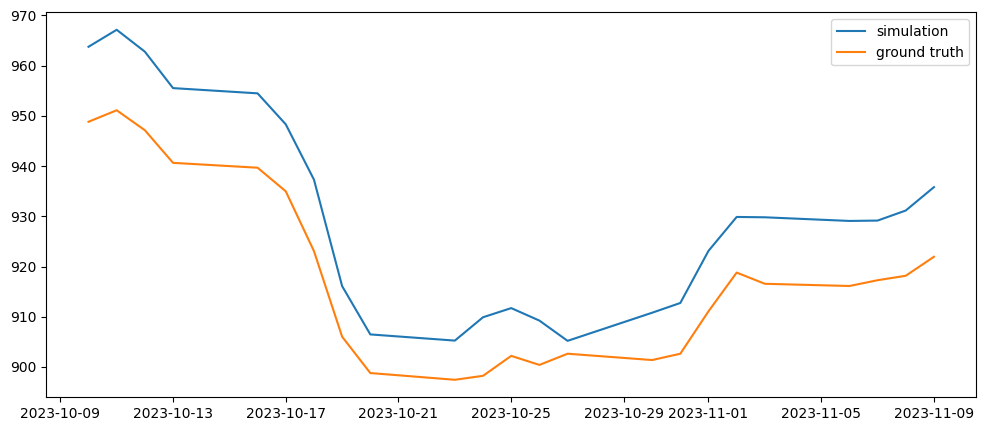

ERROR: 147.13789443043595
var:  76.01334806758393


In [39]:
print("One Month: ")
plt.figure(figsize=(12,5))
print("Three Months: ")
simulated_path_gbm_rolling_rates_av,var, ci, delta, gamma = simulate_price_path_gbm_av(avg_rate=False,last_month=True)
plt.plot(last_month['Date'],simulated_path_gbm_rolling_rates_av,label = "simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_av),torch.tensor(last_month['Price'].values))}")
print("var: ", np.mean(var))

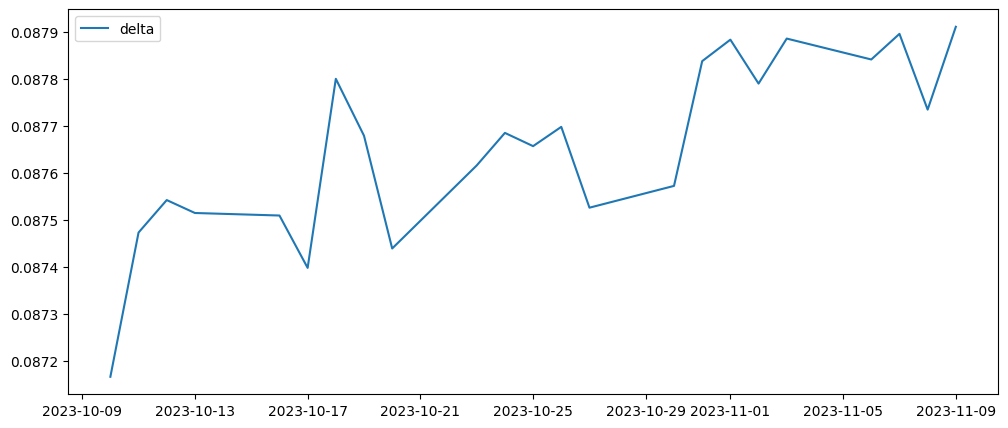

0.08765493979334006


In [40]:
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],delta,label = "delta")
plt.legend()
# plt.legend()
plt.show()
print(np.mean(delta))

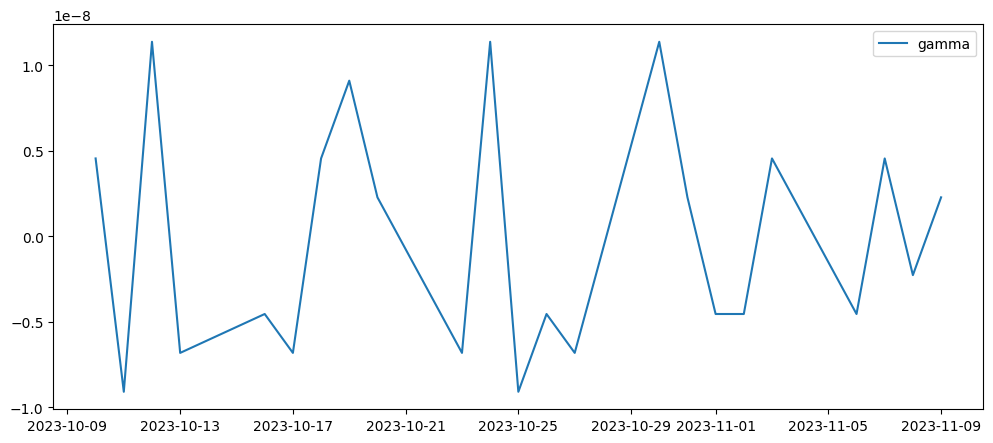

-9.885811975792699e-11


In [41]:
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],gamma,label = "gamma")
plt.legend()
# plt.legend()
plt.show()
print(np.mean(gamma))

CV simulation

In [42]:
def simulate_price_path_gbm_cv(h=0.01,avg_rate=True,last_month=False):
  path = []
  var = []
  ci = []
  delta = []
  gamma = []
  for idx, date in enumerate(interest_rate['Date']):
    orig_date=date
    split_date = str(date).split('-')
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
      continue
    relevant_data = stock.loc[f'2023-{month-3}-{day}':date]  #do we need stock price on Aug 9??? CHECK
    relevant_data.sort_values(by='Date', ascending = True, inplace = True)
    result = relevant_data['Adj Close'].values
    n0=len(result)
    dt = 1/781 #I forgot, is it daily?
    logprices=np.log(result)
    logreturns = logprices[2:n0]-logprices[1:(n0-1)]
    mu=sum(logreturns)/n0/dt
    sigma=np.std(logreturns)/np.sqrt(dt)
    St=result[n0-1] #Starting price at current date t
    Nsim=100  #Number of simulation
    m = 781-562-idx #Number of workings between Aug 9 and final fixing date

    if avg_rate:
      r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
    else:
      r =interest_rate[interest_rate['Date']==orig_date]['Rate'].values[0]/100/252
    true_mu=r-sigma**2/2  #true_mu is the mu adjusted to risk-neutral valuation

    n1=100
    pilot_var = gbmsim(n1,St,true_mu,sigma,dt,m)
    pilot_control_var = pay_off(pilot_var,781-562-idx, r_treasury=r, return_path=True)
    Tminust = 781-562
    ST_list=[path[-1] for path in pilot_var]
    ST_hat = sum(ST_list)/len(ST_list)
    pilot_control_var_hat = sum(pilot_control_var)/len(pilot_control_var)
    cov = sum([(ST_list[i]-ST_hat)*(pilot_control_var[i]-pilot_control_var_hat) for i in range(n1)])/(n1-1)

    c=-1*cov/(St**2*np.exp(2*r*Tminust)*(np.exp(sigma**2*Tminust)-1))

    og_var,Z_all = gbmsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
    ST_list=[path[-1] for path in og_var]
    cv = pay_off(og_var,781-562-idx,r_treasury=r,return_path=True)+c*(ST_list-St*np.exp(r*Tminust))

    mean = sum(cv)/len(cv)
    var.append(np.std(cv))
    ci.append((mean-1.96*np.std(cv),mean+1.96*np.std(cv)))
    path.append(mean)

    s_minus_h=gbmsim(Nsim,St-h,true_mu,sigma,dt,m,Z_all=Z_all)
    ST_minus_list=[path[-1] for path in s_minus_h]
    s_plus_h=gbmsim(Nsim,St+h,true_mu,sigma,dt,m,Z_all=Z_all)
    ST_plus_list=[path[-1] for path in s_plus_h]
    f_splush=pay_off(s_plus_h,781-562-idx,r_treasury = r,return_path=True)+c*(ST_plus_list-St*np.exp(r*Tminust))
    f_sminush=pay_off(s_minus_h,781-562-idx,r_treasury = r,return_path=True)+c*(ST_minus_list-St*np.exp(r*Tminust))

    delta.append((f_splush-f_sminush)/2/h)
    gamma.append((f_splush+f_sminush-mean*2)/h**2)

  return path,var,ci,delta,gamma

Three Month: 


<ipython-input-42-16d7f2aded3a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


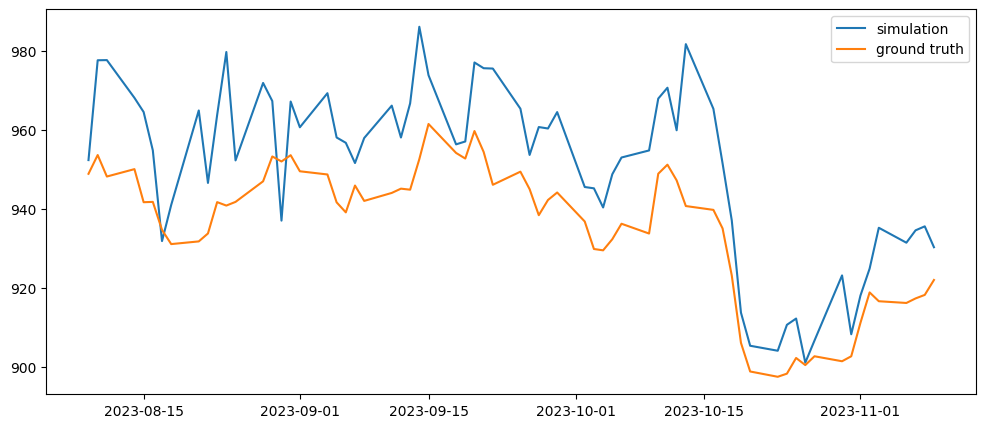

ERROR: 321.8891397830337
var:  86.19250082959981


In [43]:
# print("using one rate: ")
# simulated_path_gbm_one_rate_cv = simulate_price_path_gbm_cv()
# plt.plot(interest_rate['Date'],simulated_path_gbm_one_rate_cv)

# # plt.legend()
# plt.show()
plt.figure(figsize=(12,5))
print("Three Month: ")
simulated_path_gbm_rolling_rates_cv,var_cv,ci,delta,gamma = simulate_price_path_gbm_cv(avg_rate=False)
plt.plot(interest_rate['Date'],simulated_path_gbm_rolling_rates_cv,label = "simulation")
plt.plot(gt['Date'],gt['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_cv),torch.tensor(gt['Price'].values))}")
print("var: ", np.mean(var_cv))

One Month: 
Three Months: 


<ipython-input-42-16d7f2aded3a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


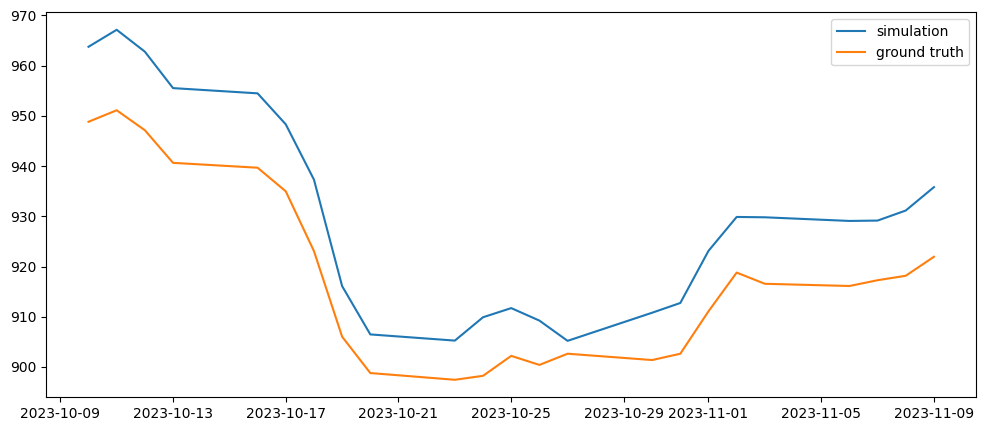

ERROR: 190.90778342220054
var:  77.35388027590243


In [44]:
print("One Month: ")
plt.figure(figsize=(12,5))
print("Three Months: ")
simulated_path_gbm_rolling_rates_cv,var, ci, delta, gamma = simulate_price_path_gbm_cv(avg_rate=False,last_month=True)
plt.plot(last_month['Date'],simulated_path_gbm_rolling_rates_av,label = "simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_cv),torch.tensor(last_month['Price'].values))}")
print("var: ", np.mean(var))

EMS

In [45]:
def EMS(SimPaths,Deltat,r):
  SimPaths = np.array(SimPaths)
  Nsim = len(SimPaths)
  m = len(SimPaths[0]) - 1
  S = np.zeros((Nsim, m + 1))
  Z = np.zeros((Nsim + 1, m))

  S[:, 0] = SimPaths[:, 0]

  for j in range(1, m + 1):
      Z[:Nsim, j - 1] = S[:, j - 1] * SimPaths[:, j] / SimPaths[:, j - 1]
      Z[Nsim, j - 1] = np.exp(-r * (j - 1) * Deltat) * np.mean(Z[:Nsim, j - 1])
      S[:, j] = SimPaths[:, 0] * Z[:Nsim, j - 1] / Z[Nsim, j - 1]
  return S


In [46]:
n0=len(result)
dt = 1/781 #I forgot, is it daily?
logprices=np.log(result)
logreturns = logprices[2:n0]-logprices[1:(n0-1)]
mu=sum(logreturns)/n0/dt
sigma=np.std(logreturns)/np.sqrt(dt)
St=result[n0-1] #Starting price at current date t
Nsim=10  #Number of simulation
m = 781-562 #Number of workings between Aug 9 and final fixing date


r=5/100/252 #BASED ON US TREASURY RATE
true_mu=r-sigma**2/2  #true_mu is the mu adjusted to risk-neutral valuation

sim_result = gbmsim(Nsim,St,true_mu,sigma,dt,m)

adjusted_sim = EMS(sim_result,dt,r)

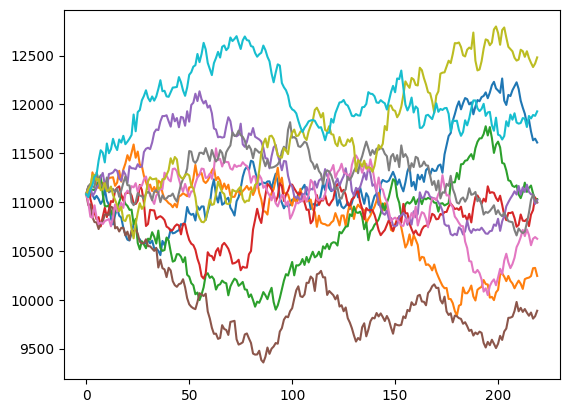

In [47]:
for plot in range(Nsim):
  plt.plot(adjusted_sim[plot], label = f"line {plot}")

# plt.legend()
plt.show()

In [48]:
def simulate_price_path_gbm_ems(h=0.01,avg_rate=True, last_month=False):
  path = []
  var = []
  ci = []
  delta = []
  gamma = []
  for idx, date in enumerate(interest_rate['Date']):
    orig_date=date
    split_date = str(date).split('-')
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
      continue
    relevant_data = stock.loc[f'2023-{month-3}-{day}':date]  #do we need stock price on Aug 9??? CHECK
    relevant_data.sort_values(by='Date', ascending = True, inplace = True)
    result = relevant_data['Adj Close'].values
    n0=len(result)
    dt = 1/781 #I forgot, is it daily?
    logprices=np.log(result)
    logreturns = logprices[2:n0]-logprices[1:(n0-1)]
    mu=sum(logreturns)/n0/dt
    sigma=np.std(logreturns)/np.sqrt(dt)
    St=result[n0-1] #Starting price at current date t
    Nsim=100  #Number of simulation
    m = 781-562-idx #Number of workings between Aug 9 and final fixing date

    if avg_rate:
      r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
    else:
      r =interest_rate[interest_rate['Date']==orig_date]['Rate'].values[0]/100/252
    true_mu=r-sigma**2/2  #true_mu is the mu adjusted to risk-neutral valuation

    sim_result, Z_all= gbmsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
    adjusted_sim = EMS(sim_result,dt,r)


    og_var,Z_all = gbmsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
    ST_list=[path[-1] for path in og_var]
    one_path = pay_off(adjusted_sim,781-562-idx,r_treasury=r,return_path=True)

    mean = sum(one_path)/len(one_path)
    var.append(np.std(one_path))
    ci.append((mean-1.96*np.std(one_path),mean+1.96*np.std(one_path)))
    path.append(mean)

    s_minus_h=gbmsim(Nsim,St-h,true_mu,sigma,dt,m,Z_all=Z_all)
    adjusted_sim_minus = EMS(s_minus_h,dt,r)
    s_plus_h=gbmsim(Nsim,St+h,true_mu,sigma,dt,m,Z_all=Z_all)
    adjusted_sim_plus = EMS(s_plus_h,dt,r)
    f_splush=pay_off(adjusted_sim_plus,781-562-idx,r_treasury = r)
    f_sminush=pay_off(adjusted_sim_minus,781-562-idx,r_treasury = r)

    delta.append((f_splush-f_sminush)/2/h)
    gamma.append((f_splush+f_sminush-mean*2)/h**2)


  return path,var,ci,delta,gamma

Three Months: 


<ipython-input-48-f19851a1ae2b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


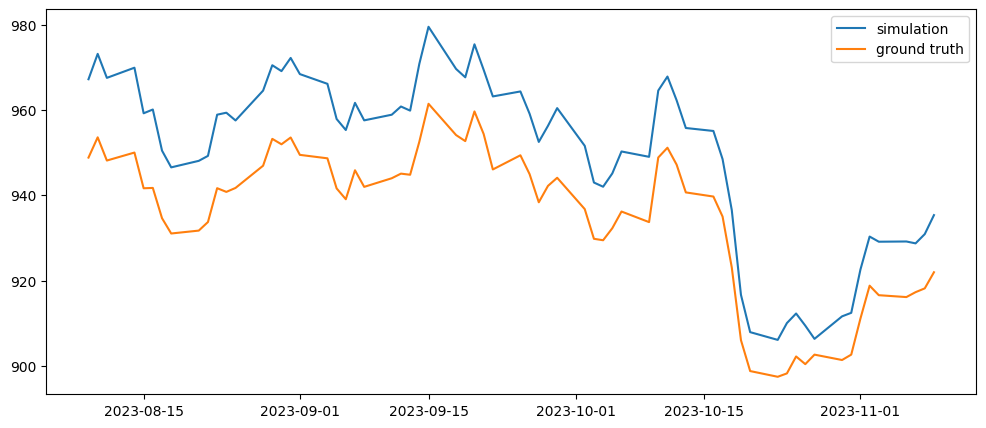

ERROR: 227.30402632254413
var:  84.89330449020817


In [49]:
# print("using one rate: ")
# simulated_path_gbm_one_rate_cv = simulate_price_path_gbm_ems()
# plt.plot(interest_rate['Date'],simulated_path_gbm_one_rate_ems)

# # plt.legend()
# plt.show()
print("Three Months: ")
plt.figure(figsize=(12,5))
simulated_path_gbm_rolling_rates_ems,var_ems,ci,delta,gamma = simulate_price_path_gbm_ems(avg_rate=False)
plt.plot(interest_rate['Date'],simulated_path_gbm_rolling_rates_ems,label = "simulation")
plt.plot(gt['Date'],gt['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_ems),torch.tensor(gt['Price'].values))}")
print("var: ", np.mean(var_ems))

One month: 


<ipython-input-48-f19851a1ae2b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


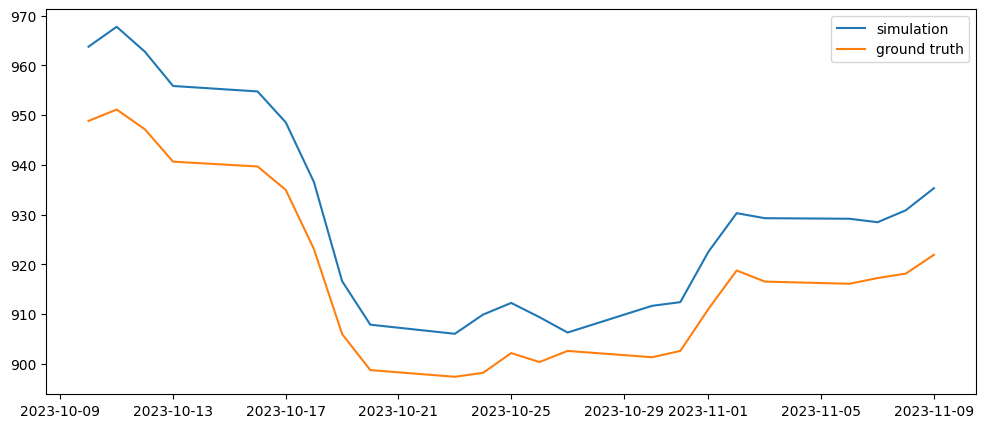

ERROR: 149.3829213136267
var:  77.84500526881845


In [50]:
print("One month: ")
plt.figure(figsize=(12,5))
simulated_path_gbm_rolling_rates_ems_one_month,var,ci,delta,gamma = simulate_price_path_gbm_ems(avg_rate=False,last_month=True)
plt.plot(last_month['Date'],simulated_path_gbm_rolling_rates_ems_one_month,label = "simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
# plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_ems_one_month),torch.tensor(last_month['Price'].values))}")
print("var: ", np.mean(var))

EMS + AV

In [51]:
def simulate_price_path_gbm_ems_av(h=0.01,avg_rate=True, last_month=False):
  path = []
  var = []
  ci = []
  delta = []
  gamma = []
  for idx, date in enumerate(interest_rate['Date']):
    orig_date=date
    split_date = str(date).split('-')
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
      continue
    relevant_data = stock.loc[f'2023-{month-3}-{day}':date]  #do we need stock price on Aug 9??? CHECK
    relevant_data.sort_values(by='Date', ascending = True, inplace = True)
    result = relevant_data['Adj Close'].values
    n0=len(result)
    dt = 1/781 #I forgot, is it daily?
    logprices=np.log(result)
    logreturns = logprices[2:n0]-logprices[1:(n0-1)]
    mu=sum(logreturns)/n0/dt
    sigma=np.std(logreturns)/np.sqrt(dt)
    St=result[n0-1] #Starting price at current date t
    Nsim=100  #Number of simulation
    m = 781-562-idx #Number of workings between Aug 9 and final fixing date

    if avg_rate:
      r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
    else:
      r =interest_rate[interest_rate['Date']==orig_date]['Rate'].values[0]/100/252
    true_mu=r-sigma**2/2  #true_mu is the mu adjusted to risk-neutral valuation

    sim_result, Z_all = gbmavsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
    adjusted_sim = EMS(sim_result,dt,r)
    one_path = pay_off(adjusted_sim,781-562-idx,r_treasury = r, return_path=True)


    # sim_result, Z_all= gbmsim(Nsim,St,true_mu,sigma,dt, m, return_z=True)
    # adjusted_sim = EMS(sim_result,dt,r)

    # og_var,Z_all = gbmsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
    # ST_list=[path[-1] for path in og_var]
    # one_path = pay_off(adjusted_sim,781-562-idx,r_treasury=r,return_path=True)

    mean = sum(one_path)/len(one_path)
    var.append(np.std(one_path))
    ci.append((mean-1.96*np.std(one_path),mean+1.96*np.std(one_path)))
    path.append(mean)

    # s_minus_h=gbmsim(Nsim,St-h,true_mu,sigma,dt,m,Z_all=Z_all)
    # adjusted_sim_minus = EMS(s_minus_h,dt,r)
    # s_plus_h=gbmsim(Nsim,St+h,true_mu,sigma,dt,m,Z_all=Z_all)
    # adjusted_sim_plus = EMS(s_plus_h,dt,r)
    # f_splush=pay_off(adjusted_sim_plus,781-562-idx,r_treasury = r)
    # f_sminush=pay_off(adjusted_sim_minus,781-562-idx,r_treasury = r)

    # delta.append((f_splush-f_sminush)/2/h)
    # gamma.append((f_splush+f_sminush-mean*2)/h**2)

  return path, var, ci
  # return path,var,ci,delta,gamma

Three Months: 


<ipython-input-51-1e36b260799e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


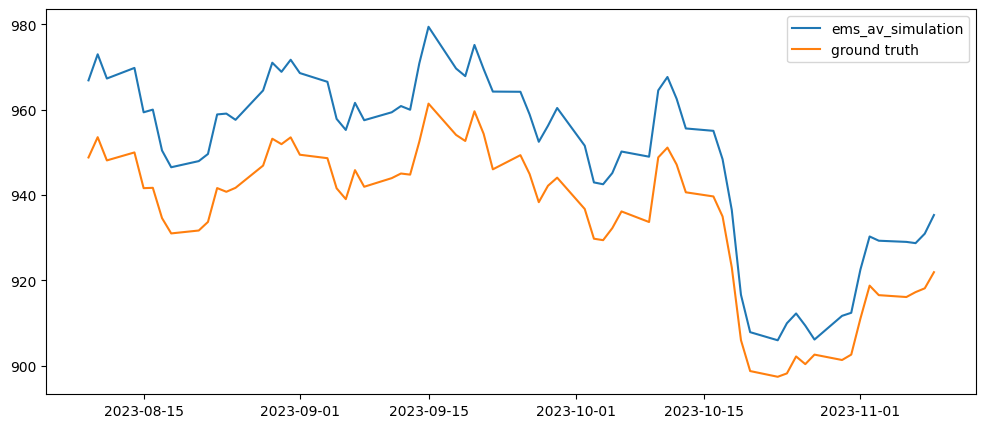

ERROR: 228.43330403117258
var:  83.19035467404034


In [52]:
print("Three Months: ")
plt.figure(figsize=(12,5))
simulated_path_gbm_rolling_rates_ems_av,var_ems_av,ci = simulate_price_path_gbm_ems_av(avg_rate=False)

plt.plot(interest_rate['Date'],simulated_path_gbm_rolling_rates_ems_av,label = "ems_av_simulation")
plt.plot(gt['Date'],gt['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_ems_av),torch.tensor(gt['Price'].values))}")
print("var: ", np.mean(var_ems_av))

EMS + CV

In [53]:
def simulate_price_path_gbm_ems_cv(h=0.01,avg_rate=True,last_month=False):
  path = []
  var = []
  ci = []
  delta = []
  gamma = []
  for idx, date in enumerate(interest_rate['Date']):
    orig_date=date
    split_date = str(date).split('-')
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
      continue
    relevant_data = stock.loc[f'2023-{month-3}-{day}':date]  #do we need stock price on Aug 9??? CHECK
    relevant_data.sort_values(by='Date', ascending = True, inplace = True)
    result = relevant_data['Adj Close'].values
    n0=len(result)
    dt = 1/781 #I forgot, is it daily?
    logprices=np.log(result)
    logreturns = logprices[2:n0]-logprices[1:(n0-1)]
    mu=sum(logreturns)/n0/dt
    sigma=np.std(logreturns)/np.sqrt(dt)
    St=result[n0-1] #Starting price at current date t
    Nsim=100  #Number of simulation
    m = 781-562-idx #Number of workings between Aug 9 and final fixing date

    if avg_rate:
      r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
    else:
      r =interest_rate[interest_rate['Date']==orig_date]['Rate'].values[0]/100/252
    true_mu=r-sigma**2/2  #true_mu is the mu adjusted to risk-neutral valuation

    n1=100
    pilot_var = gbmsim(n1,St,true_mu,sigma,dt,m)
    pilot_control_var = pay_off(pilot_var,781-562-idx, r_treasury=r, return_path=True)
    Tminust = 781-562
    ST_list=[path[-1] for path in pilot_var]
    ST_hat = sum(ST_list)/len(ST_list)
    pilot_control_var_hat = sum(pilot_control_var)/len(pilot_control_var)
    cov = sum([(ST_list[i]-ST_hat)*(pilot_control_var[i]-pilot_control_var_hat) for i in range(n1)])/(n1-1)

    c=-1*cov/(St**2*np.exp(2*r*Tminust)*(np.exp(sigma**2*Tminust)-1))

    og_var,Z_all = gbmsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
    adjusted_sim = EMS(og_var, dt, r)
    ST_list=[path[-1] for path in og_var]
    cv = pay_off(og_var,781-562-idx,r_treasury=r,return_path=True)+c*(ST_list-St*np.exp(r*Tminust))

    mean = sum(cv)/len(cv)
    var.append(np.std(cv))
    ci.append((mean-1.96*np.std(cv),mean+1.96*np.std(cv)))
    path.append(mean)

    # s_minus_h=gbmsim(Nsim,St-h,true_mu,sigma,dt,m,Z_all=Z_all)
    # ST_minus_list=[path[-1] for path in s_minus_h]
    # s_plus_h=gbmsim(Nsim,St+h,true_mu,sigma,dt,m,Z_all=Z_all)
    # ST_plus_list=[path[-1] for path in s_plus_h]
    # f_splush=pay_off(s_plus_h,781-562-idx,r_treasury = r,return_path=True)+c*(ST_plus_list-St*np.exp(r*Tminust))
    # f_sminush=pay_off(s_minus_h,781-562-idx,r_treasury = r,return_path=True)+c*(ST_minus_list-St*np.exp(r*Tminust))

    # delta.append((f_splush-f_sminush)/2/h)
    # gamma.append((f_splush+f_sminush-mean*2)/h**2)

  return path,var,ci

Three Months: 


<ipython-input-53-bd2bc50cd35d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


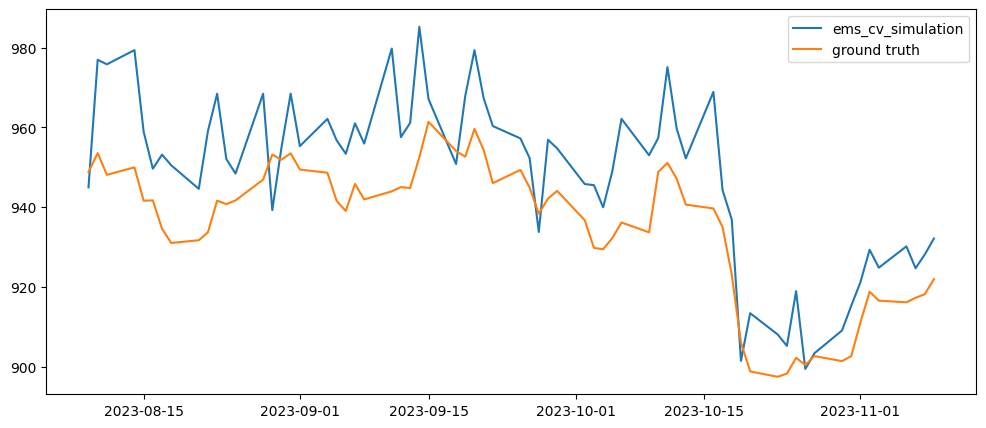

ERROR: 249.8328316458805
var:  84.3852385407372


In [54]:
print("Three Months: ")
plt.figure(figsize=(12,5))
simulated_path_gbm_rolling_rates_ems_cv, var_ems_cv, ci = simulate_price_path_gbm_ems_cv(avg_rate=False)

plt.plot(interest_rate['Date'],simulated_path_gbm_rolling_rates_ems_cv, label = "ems_cv_simulation")
plt.plot(gt['Date'],gt['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(simulated_path_gbm_rolling_rates_ems_cv),torch.tensor(gt['Price'].values))}")
print("var: ", np.mean(var_ems_cv))

**variance plot**

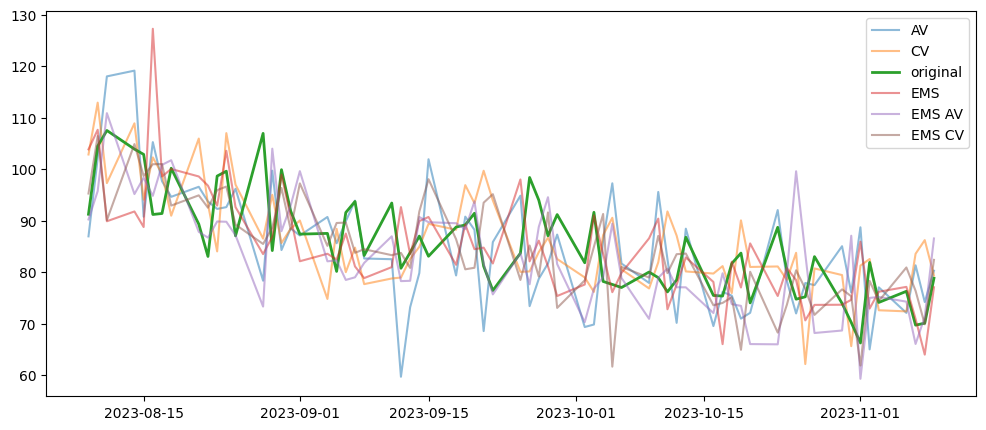

In [55]:
plt.figure(figsize=(12,5))

plt.plot(interest_rate['Date'],var_av,label = "AV", alpha=0.5)
plt.plot(interest_rate['Date'],var_cv,label = "CV", alpha=0.5)
plt.plot(gt['Date'],var_orig,label = "original", linewidth=2)
plt.plot(gt['Date'],var_ems,label = "EMS", alpha=0.5)
plt.plot(gt['Date'],var_ems_av,label = "EMS AV", alpha=0.5)
plt.plot(gt['Date'],var_ems_cv,label = "EMS CV", alpha=0.5)

plt.legend()
plt.show()

In [56]:
vars = [var_orig, var_av, var_cv, var_ems, var_ems_av, var_ems_cv]
vars = pd.DataFrame(vars).T
vars.columns = ['GBM', 'AV', 'CV', 'EMS', 'EMS_AV', 'EMS_CV']
vars.mean()

GBM       85.465990
AV        84.662321
CV        86.192501
EMS       84.893304
EMS_AV    83.190355
EMS_CV    84.385239
dtype: float64

Heston

In [57]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [58]:
class stockdataset(Dataset):
    def __init__(self, St,r,m,gt):
        self.St=St
        self.r=r
        self.m=m
        self.gt=gt

    def __len__(self):
        return len(self.St)

    def __getitem__(self, idx):
        return self.St[idx],self.r[idx],self.m[idx],self.gt[idx]

In [59]:
St_train=[]
r_train=[]
m_train=[]
gt_train=[]

St_test=[]
r_test=[]
m_test=[]
gt_test=[]
for idx, date in enumerate(interest_rate['Date']):
  split_date = str(date).split('-')
  month = int(split_date[1])
  day = int(split_date[2].split(' ')[0])
  if month==8 or month== 9 or (month == 10 and day<= 9):
    St_train.append(stock.loc[date]['Adj Close'])
    r_train.append(interest_rate[interest_rate['Date']==date]['Rate'].values[0]/100/252)
    m_train.append(781-562-idx)
    gt_train.append(gt[gt['Date']==date]['Price'].values[0])

  else:
    print(date)
    St_test.append(stock.loc[date]['Adj Close'])
    r_test.append(interest_rate[interest_rate['Date']==date]['Rate'].values[0]/100/252)
    m_test.append(781-562-idx)
    gt_test.append(gt[gt['Date']==date]['Price'].values[0])

train = stockdataset(St_train,r_train,m_train,gt_train)
test = stockdataset(St_test,r_test,m_test,gt_test)
train_loader=DataLoader(train, batch_size=8, shuffle=True)
test_loader=DataLoader(test, batch_size=8, shuffle=False)

2023-10-10 00:00:00
2023-10-11 00:00:00
2023-10-12 00:00:00
2023-10-13 00:00:00
2023-10-16 00:00:00
2023-10-17 00:00:00
2023-10-18 00:00:00
2023-10-19 00:00:00
2023-10-20 00:00:00
2023-10-23 00:00:00
2023-10-24 00:00:00
2023-10-25 00:00:00
2023-10-26 00:00:00
2023-10-27 00:00:00
2023-10-30 00:00:00
2023-10-31 00:00:00
2023-11-01 00:00:00
2023-11-02 00:00:00
2023-11-03 00:00:00
2023-11-06 00:00:00
2023-11-07 00:00:00
2023-11-08 00:00:00
2023-11-09 00:00:00


In [60]:
def generate_heston_paths(S, dt, r, kappa, theta, v_0, rho, xi, steps, Npaths, device, return_vol=False):
    size = (Npaths, steps)
    prices = torch.zeros(size, device=device)
    sigs = torch.ones(size, device=device)
    S_t = S.to(device)  # Ensure S_t is on the correct device
    v_t = v_0.to(device)  # Ensure v_t is on the correct device

    gen = MultivariateNormal(
        torch.tensor([0.0, 0.0], device=device),
        torch.tensor([[1.0, rho], [rho, 1.0]], device=device))

    for t in range(steps):
        WT = torch.stack([gen.rsample() for x in range(Npaths)])
        WT = WT * torch.sqrt(dt)
        S_t = S_t * (torch.exp((r - 0.5 * v_t) * dt + torch.sqrt(v_t) * WT[:, 0]))
        v_t = torch.abs(v_t + kappa * (theta - v_t) * dt + xi * torch.sqrt(v_t) * WT[:, 1])
        prices[:, t] = S_t
        sigs[:, t] = v_t

    if return_vol:
        return prices, sigs

    return prices

In [61]:
class heston((nn.Module)):
  def __init__(self):
    super().__init__()
    self.kappa=nn.Parameter(torch.empty(1).uniform_(0,1))
    self.theta = nn.Parameter(torch.empty(1).uniform_(0,1))
    self.xi = nn.Parameter(torch.empty(1).uniform_(0,1))
    self.rho = nn.Parameter(torch.empty(1).uniform_(-1,1))
    self.v_0 = nn.Parameter(torch.empty(1).uniform_(0,1))
    self.Nsim= 100
    self.dt=torch.tensor(1/781)

  def forward(self,St,r,m):
    device = St.device  # Get the device from the input tensor
    result = []
    for i in range(len(St)):
        sim_result = generate_heston_paths(
            St[i], self.dt, r[i], kappa=self.kappa, theta=self.theta,
            v_0=self.v_0, rho=self.rho, xi=self.xi, steps=m[i],
            Npaths=self.Nsim, return_vol=False, device=device)  # Pass the device
        result.append(pay_off(sim_result, m[i], r_treasury=r[i], enable_torch=True))

    return torch.stack(result)


In [64]:
model=heston().to(DEVICE)
criterion=torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
best_loss=100000
final_estimate=[]
for epoch in range(20):
  model.train()
  for batch in train_loader:
    optimizer.zero_grad()
    result = model(batch[0].to(DEVICE),batch[1].to(DEVICE),batch[2].to(DEVICE))
    loss = criterion(result,batch[3].to(DEVICE))
    loss.backward()
    optimizer.step()
    idx=0
    for p in model.parameters():
      if idx==3:
        p.data.clamp_(-1,1)
      else:
        p.data.clamp_(0.0001,1)

      idx=idx+1

  model.eval()
  total_loss=0
  estimate=[]
  for batch in test_loader:
    bs=batch[0].shape[0]
    optimizer.zero_grad()
    result = model(batch[0].to(DEVICE),batch[1].to(DEVICE),batch[2].to(DEVICE))
    loss = criterion(result,batch[3].to(DEVICE))
    total_loss=loss.item()+loss
    estimate.append(result)

  total_loss=total_loss
  if total_loss<best_loss:
    final_estimate=torch.cat(estimate).detach().cpu().numpy()
    best_loss=total_loss

    print(f'Loss: {total_loss}')
    print(f'kappa: {model.kappa} theta:{model.theta} xi:{model.xi}, rho: {model.rho}, v_0: {model.v_0}')

    best_kappa = model.kappa.detach().cpu().numpy()
    best_theta = model.theta.detach().cpu().numpy()
    best_xi = model.xi.detach().cpu().numpy()
    best_rho = model.rho.detach().cpu().numpy()
    best_v_0 = model.v_0.detach().cpu().numpy()


In [66]:
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],final_estimate,label = "simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
plt.show()

In [67]:
def generate_heston_paths_np(S, dt, r, kappa, theta, v_0, rho, xi, steps, Npaths, WT_all = None, return_vol=False, return_WT=False):
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.ones(size)
    S_t = S
    v_t = v_0
    if WT_all is None:
      WT_all=[]
      for t in range(steps):
          WT=np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rho],[rho,1]]), size=Npaths) * np.sqrt(dt)
          S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) )
          v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
          prices[:, t] = S_t
          sigs[:, t] = v_t
          WT_all.append(WT)
    else:
      for t in range(steps):
          WT=WT_all[t]
          S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) )
          v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
          prices[:, t] = S_t
          sigs[:, t] = v_t
    if return_vol:
        return prices, sigs

    if return_WT:
      return prices,WT_all

    return prices

In [68]:
def simulate_price_path_heston(kappa, theta, v_0, rho, xi,h=0.01,avg_rate=False, last_month=True):
  kappa=kappa
  theta=theta
  xi=xi
  v_0=v_0
  rho=rho
  path = []
  var = []
  ci = []
  delta = []
  gamma = []
  for idx, date in enumerate(interest_rate['Date']):
    orig_date=date
    split_date = str(date).split('-')
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
      continue
    else:
      St=stock.loc[date]['Adj Close']
      Nsim=100  #Number of simulation
      m = 781-562-idx #Number of workings between Aug 9 and final fixing date

      if avg_rate:
        r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
      else:
        r =interest_rate[interest_rate['Date']==orig_date]['Rate'].values[0]/100/252

      dt = 1/781
      sim_result, WT = generate_heston_paths_np(St, dt, r, kappa, theta, v_0, rho, xi, m, Nsim,return_WT=True)
      # sim_result = generate_heston_paths(torch.tensor(St), torch.tensor(dt), torch.tensor(r), torch.tensor(kappa), torch.tensor(theta), torch.tensor(v_0), torch.tensor(rho), torch.tensor(xi), m, Nsim)
      # sim_result=sim_result.detach().cpu().numpy()
      one_path = pay_off(sim_result,781-562-idx,r_treasury = r, return_path=True)

      mean = sum(one_path)/len(one_path)
      var.append(np.std(one_path))
      ci.append((mean-1.96*np.std(one_path),mean+1.96*np.std(one_path)))
      path.append(mean)

      s_minus_h=generate_heston_paths_np(St-h, dt, r, kappa, theta, v_0, rho, xi, m, Nsim,WT_all=WT)
      s_plus_h=generate_heston_paths_np(St+h, dt, r, kappa, theta, v_0, rho, xi, m, Nsim,WT_all=WT)
      f_splush=pay_off(s_plus_h,781-562-idx,r_treasury = r)
      f_sminush=pay_off(s_minus_h,781-562-idx,r_treasury = r)

      delta.append((f_splush-f_sminush)/2/h)
      gamma.append((f_splush+f_sminush-mean*2)/h**2)

  return path, var, ci, delta, gamma

In [69]:
best_kappa=0.352
best_theta=0.45
best_xi = 0.5
best_rho = -0.557
best_v_0=0.0001
# simulate_price_path_heston(kappa=best_kappa, theta=best_theta, v_0=best_v_0, rho=best_rho, xi=best_xi)

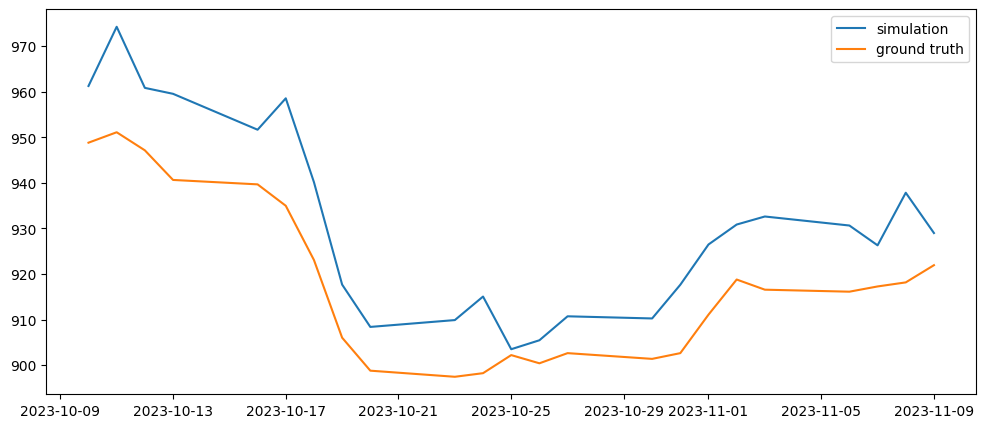

ERROR: 202.70300034536248
var:  52.6577409802689


In [70]:
path_h, var_h, ci, delta, gamma = simulate_price_path_heston(kappa=best_kappa, theta=best_theta, v_0=best_v_0, rho=best_rho, xi=best_xi)
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],path_h,label = "simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(path_h),torch.tensor(last_month['Price'].values))}")
print("var: ", np.mean(var_h))

In [71]:
print(best_kappa)

0.352


In [72]:
path_h_3mth, var_h_3mth, ci_3mth, delta_3mth, gamma_3mth = simulate_price_path_heston(kappa=best_kappa, theta=best_theta, v_0=best_v_0, rho=best_rho, xi=best_xi, last_month=False)

In [90]:
# heston_mse = calculate_mse(path_h_3mth, rel_3_months['Price'], avg = True)
heston_mse = calculate_mse(path_h, last_month['Price'], avg = True)

In [91]:
heston_mse

202.70300034536248

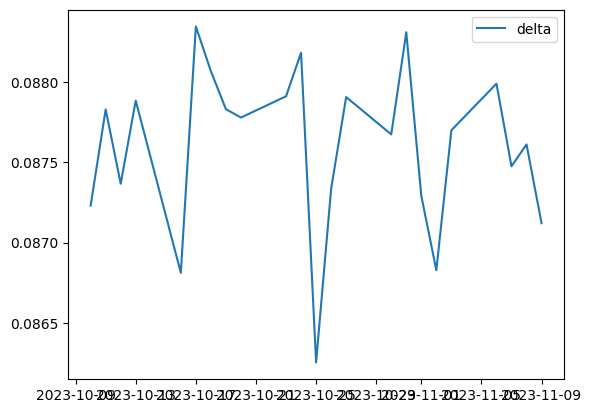

In [75]:
plt.plot(last_month['Date'],delta,label = "delta")
plt.legend()

In [76]:
print("Heston model Delta:", np.mean(delta))

Heston model Delta: 0.08759686381935076


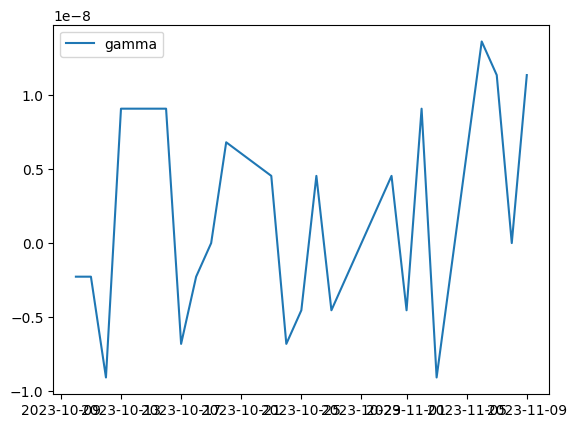

In [77]:
plt.plot(last_month['Date'],gamma,label = "gamma")
plt.legend()

In [78]:
print("Heston model Gamma:", np.mean(gamma))

Heston model Gamma: 1.4828717963689048e-09


# Vasicek Interest Rate Model (Short Rate Model)

In [79]:
import numpy as np

def vasicek_sim(n, kappa, theta, sigma, dt, r0=0.02):
    r = np.zeros(n)
    r[0] = r0

    for i in range(1, n):
        dW = np.random.normal()
        r[i] = r[i-1] + kappa * (theta - r[i-1]) * dt + sigma * np.sqrt(dt) * dW

    return r

def simulate_price_path_vasicek(h=0.01, rolling_rate=False, last_month=False, kappa=0.1, theta=0.02, sigma=0.01):
    path = []
    var = []
    ci = []
    delta = []
    gamma = []
    sigma_all = []
    for idx, date in enumerate(interest_rate['Date']):
      orig_date=date
      split_date = str(date).split('-')
      month = int(split_date[1])
      day = int(split_date[2].split(' ')[0])
      if last_month and (month==8 or month == 9 or (month == 10 and day<= 9)):
        continue
      else:
        relevant_data = stock.loc[f'2023-{month-3}-{day}':date]  #do we need stock price on Aug 9??? CHECK
        relevant_data.sort_values(by='Date', ascending = True, inplace = True)
        result = relevant_data['Adj Close'].values
        n0=len(result)
        dt = 1/781 #I forgot, is it daily?
        logprices=np.log(result)
        logreturns = logprices[2:n0]-logprices[1:(n0-1)]
        mu=sum(logreturns)/n0/dt
        sigma=np.std(logreturns)/np.sqrt(dt)
        St=result[n0-1] #Starting price at current date t
        Nsim=100  #Number of simulation
        m = 781-562-idx #Number of workings between Aug 9 and final fixing date
        sigma_all.append(sigma)

        if not rolling_rate:
          r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
        else:
          # r=sum(interest_rate['Rate'])/len(interest_rate['Rate'])/100/252
          mask = (interest_rate['Date'] >= f'2023-{month-3}-{day}') & (interest_rate['Date'] <= date)
          r=interest_rate.loc[mask]
          r = sum(r['Rate'].values)/m/100/252
        # Simulate short rates using Vasicek model
        short_rates = vasicek_sim(m, kappa, theta, sigma, dt)

        true_mu = short_rates[-1] - sigma**2 / 2  # Adjusted for risk-neutral valuation

        sim_result, Z_all = gbmsim(Nsim,St,true_mu,sigma,dt,m, return_z=True)
        one_path = pay_off(sim_result,781-562-idx,r_treasury = r, return_path=True)

        mean = sum(one_path)/len(one_path)
        var.append(np.std(one_path))
        ci.append((mean-1.96*np.std(one_path),mean+1.96*np.std(one_path)))
        path.append(mean)

        s_minus_h=gbmsim(Nsim,St-h,true_mu,sigma,dt,m,Z_all=Z_all)
        s_plus_h=gbmsim(Nsim,St+h,true_mu,sigma,dt,m,Z_all=Z_all)
        f_splush=pay_off(s_plus_h,781-562-idx,r_treasury = r)
        f_sminush=pay_off(s_minus_h,781-562-idx,r_treasury = r)

        delta.append((f_splush-f_sminush)/2/h)
        gamma.append((f_splush+f_sminush-mean*2)/h**2)

    print(f"sigma: {sum(sigma_all)/len(sigma_all)}")

    return path, var, ci, delta, gamma, short_rates


In [80]:
result = simulate_price_path_vasicek()

path, var, ci, delta, gamma, short_rate_paths = result

print("Simulated Price Path:")
for i, value in enumerate(path):
    print(f"Day {i+1}: {value}")

<ipython-input-79-f47c9dfd4185>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data.sort_values(by='Date', ascending = True, inplace = True)


sigma: 0.1851682190324757
Simulated Price Path:
Day 1: 983.8829440435338
Day 2: 1004.5221903531228
Day 3: 982.5064175189378
Day 4: 966.0494555094701
Day 5: 1001.2579120333247
Day 6: 970.12404459583
Day 7: 977.327056554021
Day 8: 977.7092647709327
Day 9: 955.9029732030828
Day 10: 971.4895380391866
Day 11: 945.1414612806345
Day 12: 953.556537532588
Day 13: 989.0841041086751
Day 14: 985.0141028943618
Day 15: 1029.0143872939527
Day 16: 975.3743241469938
Day 17: 962.6919648924471
Day 18: 991.3744170753532
Day 19: 948.5660552899386
Day 20: 990.2031288903803
Day 21: 945.1119693486052
Day 22: 932.658297706227
Day 23: 978.2408172624745
Day 24: 991.337099966565
Day 25: 946.8326926631615
Day 26: 986.6860393191641
Day 27: 991.8437971494745
Day 28: 976.2536776906907
Day 29: 990.7986744293604
Day 30: 961.1480665878427
Day 31: 970.258050957947
Day 32: 1024.5103881165621
Day 33: 953.8095948277409
Day 34: 1022.1685454013848
Day 35: 1011.7135613215569
Day 36: 948.5498338093228
Day 37: 967.2950504461237


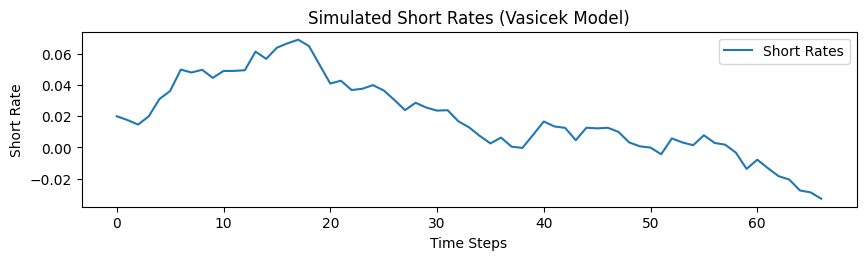

In [81]:
# Plotting short rates
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(short_rate_paths[:67], label='Short Rates')
plt.title('Simulated Short Rates (Vasicek Model)')
# from Aug 9 to Nov 9
plt.xlabel('Time Steps')
plt.ylabel('Short Rate')
plt.legend()

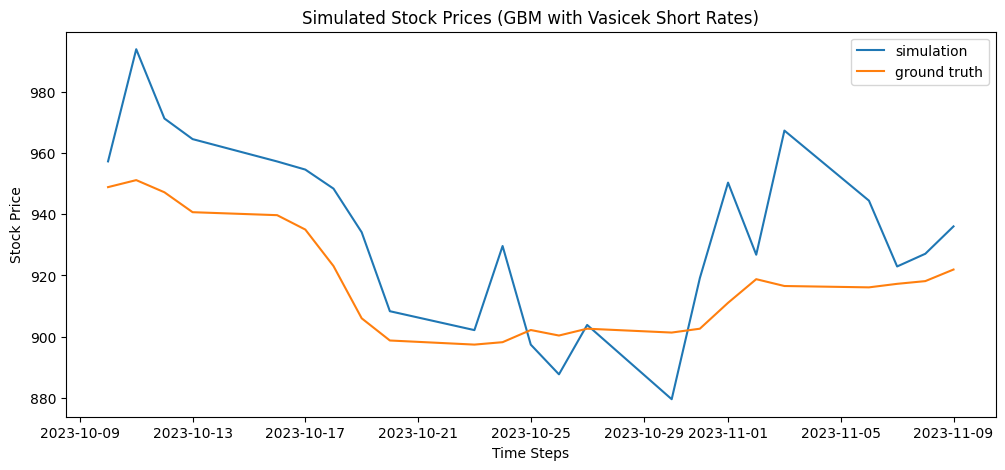

ERROR: 542.4661224610853
var:  85.76290512021947


In [82]:
# Plotting simulated prices
plt.figure(figsize=(12,5))
plt.title('Simulated Stock Prices (GBM with Vasicek Short Rates)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.plot(last_month['Date'],path[-23:],label = "simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
plt.show()
print(f"ERROR: {criterion(torch.tensor(path[-23:]),torch.tensor(last_month['Price'].values))}")
print("var: ", np.mean(var))

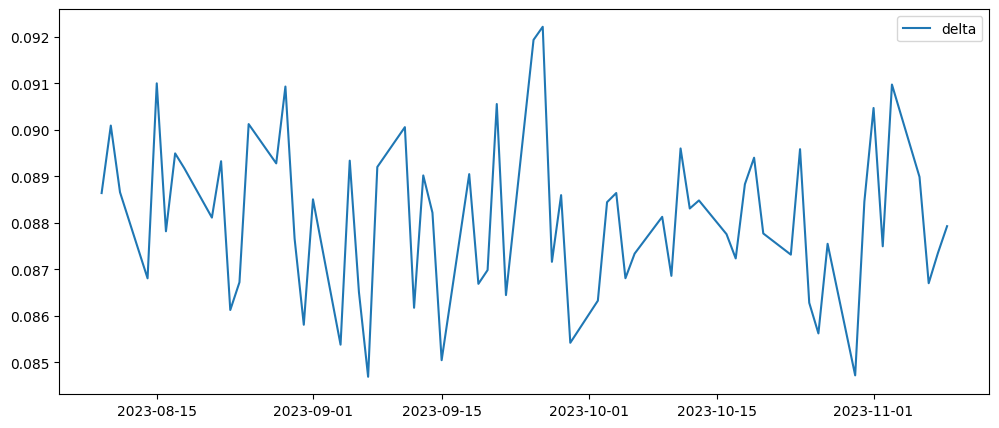

In [83]:
plt.figure(figsize=(12,5))
plt.plot(interest_rate['Date'],delta,label = "delta")
plt.legend()
# plt.legend()
plt.show()

In [84]:
print(np.mean(delta))

0.08809667854929605


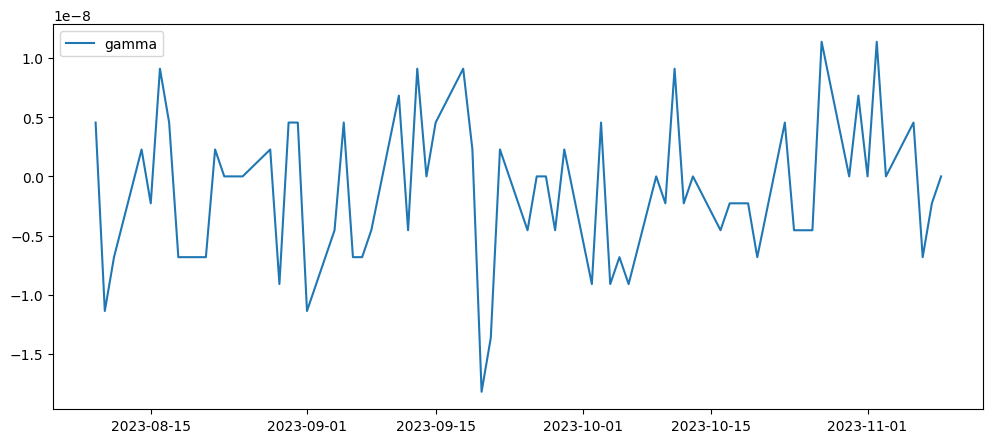

In [85]:
plt.figure(figsize=(12,5))
plt.plot(interest_rate['Date'],gamma,label = "gamma")
plt.legend()
# plt.legend()
plt.show()

In [86]:
print(np.mean(gamma))

-1.1199001924815907e-09


In [87]:
mse_result_vasiceksrm = calculate_mse(path[-23:], last_month['Price'], avg=True)

print(f"Mean Squared Error (MSE): {mse_result_vasiceksrm}")

Mean Squared Error (MSE): 542.4661224610853


In [88]:
criterion(torch.tensor(path[-23:]),torch.tensor(last_month['Price'].values))

tensor(542.4661, dtype=torch.float64)

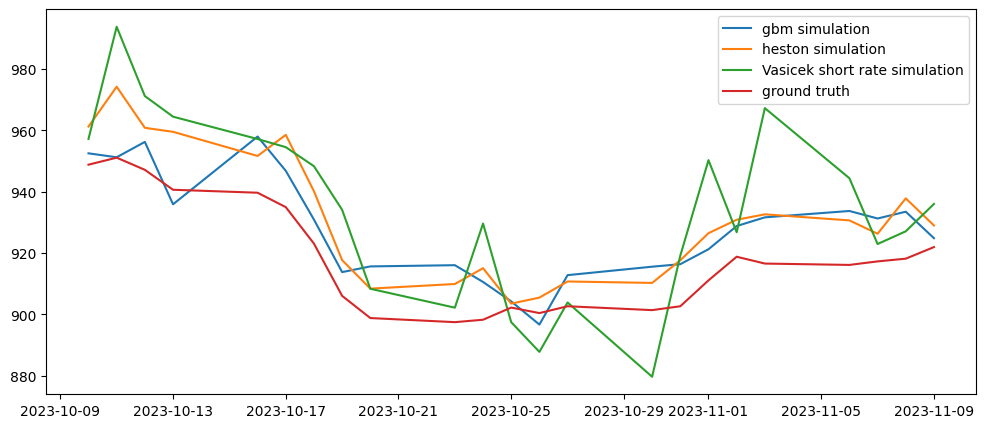

In [89]:
plt.figure(figsize=(12,5))
plt.plot(last_month['Date'],simulated_path_gbm_rolling_rates_one_month,label = "gbm simulation")
plt.plot(last_month['Date'],path_h,label = "heston simulation")
plt.plot(last_month['Date'],path[-23:],label = "Vasicek short rate simulation")
plt.plot(last_month['Date'],last_month['Price'],label = "ground truth")
plt.legend()
plt.show()

In [92]:
print(f"Mean Squared Error for GBM (MSE): {mse_result_gbm}")
print(f"Mean Squared Error for Heston model (MSE): {heston_mse}")
print(f"Mean Squared Error for Vasicek short rate model (MSE): {mse_result_vasiceksrm}")

Mean Squared Error for GBM (MSE): 273.38007527914453
Mean Squared Error for Heston model (MSE): 202.70300034536248
Mean Squared Error for Vasicek short rate model (MSE): 542.4661224610853
